<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**<font size=6>🍿Netflix</font>**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<details>
  <summary><small>Sharing consent: <mark>[ X ]</mark></summary>
  <div>
We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is <b>optional</b> and this decision will not affect our grade in any way. <font color=gray><i>
Instructions: If ok with sharing your Colab for educational purposes, leave "X" in the check box.</i></font></small></div>

In [ ]:
# from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

In [ ]:
# !pip install --upgrade imgaug==0.2.5 >> log  # avoids warning/conflict with scipy upgrade
# !pip install --upgrade scipy >>log  # upgrades 1.4 to 1.8
# !pip install --upgrade --force-reinstall --no-deps kaggle >> log  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >>log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json >> log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 10feb25-netflix          # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>

In [ ]:
%%time
%%capture
%reset -f
!cp metadata.json METADATA
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=120): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 3.39 s, sys: 342 ms, total: 3.73 s
Wall time: 1min 21s


The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
0,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128698,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
dfMtx.info()   # note the datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128699 entries, 0 to 128698
Columns: 380 entries, 1 to 380
dtypes: float64(380)
memory usage: 373.1 MB


The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

rtg,4,3,5,2,1,0
count,2451087,2120585,1628122,842056,340222,20000


In [ ]:
dfMov = pd.read_csv('movies.csv'); dfMov.head(2)   # load movie attributes

,mid,Year,Name,voteAvg,voteCnt,popularity,duration,income,budget,releaseDate,...,origLang,spokenLang,ttl,origTtl,URL,kwds,desc,prodComp,prodCtry,tagline
0,1,2004,The Village,6.2,1071,27.49,108.0,256697520,60000000,7/30/04,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Village,The Village,NaN,"[{""id"": 1328, ""name"": ""secret""}, {""id"": 5774, ...",When a willful young man tries to venture beyo...,"[{""name"": ""Scott Rudin Productions"", ""id"": 258...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",There is no turning back
1,2,1997,Liar Liar,6.4,1424,26.72,86.0,181000000,45000000,3/21/97,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Liar Liar,Liar Liar,NaN,"[{""id"": 387, ""name"": ""california""}, {""id"": 102...",Fletcher Reede is a fast-talking attorney and ...,"[{""name"": ""Imagine Entertainment"", ""id"": 23}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",Trust me.


In [ ]:
tmr = Timer()

⏳ started. You have 120 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Impute missing values for SVD initialization</b><h3>

In [ ]:
if 'dfMtx' in vars(): del dfMtx   # release ~400MB RAM
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.mean())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies

In [ ]:
dfX.iloc[:2,:30]   # original matrix with NaN's

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
2,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN


In [ ]:
dfX_est.loc[:2,:30]  # naive imputation with column means

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,3.27,3.52,2.0,3.69,3.29,3.63,5.00,3.53,2.78,3.37,...,3.88,3.04,3.0,3.22,3.52,5.0,3.06,3.12,3.37,3.53
2,5.00,3.52,5.0,3.00,3.29,3.63,4.26,3.53,2.78,3.37,...,3.88,3.04,5.0,3.22,3.52,3.0,3.06,3.12,3.00,3.53


<font color=green><h3><b>$\beta$. Apply truncated SVD</b><h3>

In [ ]:
np.random.seed(0)
for _ in range(100):                             # apply truncated SVD approximation a few times
  U, D, Vt = svds(dfX_est.to_numpy(), k=5, maxiter=100, tol=1e-2)     # find k eigenvectors (U,V) and eigenvalues (D)
  dfX_est.loc[1:n, 1:p] = U @ np.diag(D) @ Vt  # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
  loc = ~np.isnan(dfX)     # mark locations of non-NaN's
  dfX_est[loc] = dfX[loc]  # place original/known ratings back into estimated uid×mid matrix
dfX_est.loc[:2,:30]        # a "better" approximation of underlying ratings distribution (or so we hope ;) )

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,2.43,3.40,2.0,2.81,3.01,2.91,5.00,4.08,2.42,3.14,...,5.08,2.32,3.0,2.96,2.98,5.0,2.16,1.90,2.98,3.50
2,5.00,4.65,5.0,3.00,3.69,4.66,4.86,4.57,3.49,4.07,...,4.14,3.60,5.0,3.51,3.59,3.0,3.71,3.48,3.00,3.58


In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().reset_index().round(0).astype(int).rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfX_est_L.merge(dfK, on=['mid','uid'], suffixes=['','_']).drop('rtg_', axis=1)
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg'].clip(1, 5)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK

,mid,uid,rtg
1,1,1,2
147061,1,388,3
...,...,...,...
5568899,379,14655,3
5647180,380,14861,4


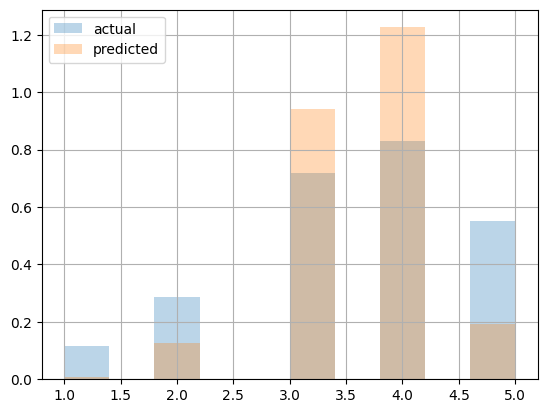

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(dfK[['rtg']].sort_index(), '🍿Baseline🐍_tuned')

<font color=green><h3><b>$\gamma$. Idea Documentation</b></h3>
<details>
  <summary>Instructions</summary>
  <div>


1. **Audience**. Your peers who will learn from your Colab and ideas therein.
1. **Importance**. The ML/DL ideas are not entirely random, but are based on prior experience and systematized/organized experiments. We'd like students to share and learn from idea generation to idea experimentation process done in our class using tools learned thus far.
1. **Format**. Keep it concise/precise in consistent font/presentation. Include numbers/IDs to your References, such as [1] or [[Géron22]](https://scholar.google.com/scholar?cluster=498861685923226475), where these are defined in your References section below. This helps link your ideas/experiments to external ideas.
1. **Reproducibility**. Your description should contain reasonable details needed for reproducibility, i.e. describe the state of your modeling pipeline before the change is made, what is changed and how the idea was discovered, and what improvement it resulted in. Thus, peers can try this idea with an expectation of the value it brings. See examples below.
1. **Bonus** points for the exceptional/exemplary/educational documentation (see grading rubric).
****
1. **TODO**: Describe the key idea in your work in the following format (similar to a "micro publication"):
  1. **Title**. Give each idea a descriptive name (i.e. a micro abstract).
    1. Ex(ample). <i>"Thresholding carat feature outliers improves MAE by 3% on public LB"</i>
  1. **Idea Discovery**. What led you to this idea? Was it some [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis), familiarity with this dataset or some of the features?
    1. Ex. <i>"We plotted all univariate distributions of variables and discovered that diamond carat had unreasonable (but rare) values below and above [0,10] interval, when plotted carat's histogram in the train and test sets, which contained 10 and 3 such outliers respectively. We decided to use 10 as a reasonable threshold because it is 99th percentile of carat values in the 20K baseline sample. See our histogram plot below [plot here]. "</i>
  1. **Finding's Importance**. Describe why you think the idea was important to proceed with.
    1. Ex. <i>"We use a linear model, the slope of which is sensitive to outliers on the periphery of the feature space domain. The fitted hyperplane slopes in the direction of the extreme training feature values thereby mapping a non-existent relation between carat size and diamond price, which is not expected to repeat in the test set. "</i>
  1. **Experiment Setup**.
  How did you set up experiments to test your idea? What resources were helpful? What metric did you select, why and what values did you observe?
    1. Ex. <i>"To alleviate the impact of the outlying feature values, we need to either remove observations with extreme values, or somehow cap them (to stay within the distribution of the other carat values) or use a model insensitive to outliers (such as robust regression). We learned 3 suitable methods for treating outliers in [ref]: ... [It'd be great to briefly describe each method] We tried each one on a Baseline model, while keeping the competition-required [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) metric. We tested each method locally on the seeded 50/50 split of the 20K training set sampled in baseline Colab."</i>
  1. **Results**. What was the result or metric improvement from implementing the experiment locally and/or on public LB?
    1. Ex. <i>"Baseline MAE was 539.1257546465 in public LB and 530 in local default experiment with 50/50 train-test split. When applied on the same-seed split, Methods 1,2,and 3 showed 1%, 2%, and 5% improvement on the test set. When uploaded to public LB, Method 3 showed a 3% improvement. So, we decided to keep method 3."</i>

</div> </details>
</font>


<font color=green><h4><b>Task 1. Preprocessing Ideas</b></h4>
<details>
  <summary>Instructions</summary>
  <div>Explain a <b>key idea</b> that helped in <b>preprocessing pipeline</b>. This may be about some feature engineering, tricky subsampling, clustering, dimension reduction, etc. Use the format in TODO specified above. Remember to provide citation references for the peers to read more into your work.
</div> </details>
</font>

1. **Title**: Non-Global Mean Filling
1. **Idea Discovery**: While looking at the data only mid and uid were utilized to learn how to determine rtg. The null values were filled in with the global mean.
1. **Finding's Importance**: Being able to fill the null values by other data might help the model determine better pattern recognition, thus performing better.
1. **Experiment Setup**: The evaluation of model performance was done via grid search utilizing 5-fold cross validation with accuracy as the determining factor. Three different categories were created and utilized to see if any would aid the model. Genre Group, mean determined from the main genra a movie was placed in (if more than one, most common accross the board was chosen). Production Companies, mean determined from movies had the same production company. Decade, mean based on values for other movies of the same decade. The model was trained utilizing mean filling via one of the categories and then a cross of the different categories and finally all three categories.
1. **Results**: Suprisingly the model performed best with just the basic global mean as the filler for null values. This may be due to overfitting of data points or because the model had no sense of what movies were from what section as inserting the data was not the simplest.

1. **Title**: Movie Selection and User Trimming
1. **Idea Discovery**: Exploring the dataset one thing became aparent, it was quite expansive. Due to this expansivness much of the data could be redundent or causing the model to overfit, especially since null values were filled in via the mean.
1. **Finding's Importance**: Ensuring that there is not too much data for the model to handle can not only increase model accuracy but also increase model speed as it has less data to handle.
1. **Experiment Setup**: There were two different breaks that were attempted to down select the data. The first was by removing users who rated less than a select amount of movies. The second was restricting the movies down to movies that had more known ratings. There were a few numbers attempted for each and the model was tested for accuracy via 5 fold cross validation.
  1. Movie Ratings Counts: [50, 100, 1000, 1250, 1500]
  2. User Rating Counts: [15, 25, 50, 75]
1. **Results**:
  * Due to the sheer size of the dataset the movies were not cut down until around 1000 while a smaller amount of user ratings could cut down the dataset with ease.
  * Alternative imputation methods **did not improve results**, likely because they **over-clustered movies** into subgroups that were too restrictive.  
  * **Possible reason**: Users rate movies differently even within genres or decades (e.g., "The Matrix" and "The Emoji Movie" are both sci-fi but have very different reception).  
  * Overall, the model performed best utilzing the full dataset, the robust nature of the downsampling may have removed necessary datapoints for the model to learn from.

<font color=green><h4><b>Task 2. Modeling Ideas</b></h4>
<details>
  <summary>Instructions</summary>
  <div>Explain a <b>key idea</b> that helped with <b>model selection</b> in the format specified above. This may include tuning model parameters (perhaps a grid search with specific parameter range) or some other experiments, search/choice of the suitable model, experiments with postprocessing of model predictions, etc. Use the format in TODO specified above. Remember to provide citation references for the peers to read more into your work.
</div> </details>
</font>

1. **Title**: SVD Model Selection
1. **Idea Discovery**: After experimenting with different models, including Surprise's SVD and Scipy's SVD, it was observed that the tuned loop version of Scipy SVD consistently outperforms the others in terms of accuracy and RMSE.
1. **Finding's Importance**: The findings suggest that using Scipy’s SVD implementation with appropriate parameters, such as the number of factors and iterations, provides the best balance between accuracy and RMSE. This result has significant implications for further optimization of recommendation systems.
1. **Experiment Setup**: We evaluated the performance of Surprise SVD and Scipy SVD models with movie means imputation using stratified 5-fold cross-validation.

    1. Surprise SVD:
      - n_factors: 8,
      - n_epochs: 15,
      - lr_all: 0.005,
      - reg_all: 0.005,
      - random_state: 42

    2. Scipy SVD:
      - n_loop: 100,
      - k: 3,
      - maxiter: 100,
      - tol: 1e-2,

1. **Results**:

    1. Surprise SVD:
      - Average Accuracy: 0.4054 ± 0.0008
      - Average RMSE: 1.0141 ± 0.0004
    2. Scipy SVD:
      - Average Accuracy: 0.4084 ± 0.0002
      - Average RMSE: 0.9999 ± 0.0006

    Conclusion: Scipy SVD with tuned latent factors performed better than the tuned Surprise SVD.

1. **Title**: Extra Model Selections
1. **Idea Discovery**: While SVD models had been looked at, they may not have been the best model to utilize for this project.
1. **Finding's Importance**: Every model has its strengths and weaknesses, testing other models to ensure there isn't more performance gain from them is incredibly useful.
1. **Experiment Setup**: Three different models were compared and tested against eachother to see if any of them performed better. Each model was then compared to our baseline SVD model.
  2. rPCA
    1. mu: [None, 0.05]
    2. lambda: [None, 0.1]
    3. max_iter: [1000, 2500, 5000]
    4. tol: [1e-6, 1e-8]
  2. kNNWithMeans
    1. k: [40, 20, 60]
    2. min_k: [1, 5, 10]
    3. sim_options: [None, {"name": "cosine","user_based": False}]
  3. SVD++
    1. n_factors: [5, 10, 20]
    2. n_epochs: [5, 10, 20]
    3. cache_ratings: [True, False]
    4. lr_all: [0.01, 0.05, 0.1, 0.2]
1. **Results**:
  * rPCA performed poorly
    * Best Models Accuracy: 0.365
  * SVD++ peformed better than rPCA but at the cost of time performance
    * Best Models Accuracy: 0.382
  * kNNWithMeans also performed better but would take up to 10-15 minutes to gain results
    * Best Models Accuracy: 0.384

  Basice SVD was deemed the best of both worlds, having reasonable performance performed in the alotted timeframe.

<font color=green><h3><b>$\delta$. References</b></h3>
<details>
  <summary>Instructions</summary>
  <div>

1. Cite your sources to help your peers learn from these (and to avoid plagiarism).
1. HOML textbook should be cited, since we used it in this week's learning.
1. Use Google Scholar to draw [APA](https://en.wikipedia.org/wiki/American_Psychological_Association) citation format for books and publications.
1. Cite [StackOverflow](https://stackoverflow.com/), YouTube videos, package docs, open-access textbooks/publicaitons and other meaningful internet resources that you used.
1. We may reward exceptional and meaningful citations (not just a list of [SKL](https://scikit-learn.org/stable/)/[TF](https://www.tensorflow.org/) manual pages and a list of articles.) For example, if you used an idea from a publication, indicate it in TGP with a number that corresponds to its reference in References.

</div> </details>
</font>

1. SciPy. (n.d.). Sparse linear algebra (scipy.sparse.linalg). SciPy Documentation. Retrieved February 23, 2025, from https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html
1. Surprise. (n.d.). Matrix factorization-based algorithms: SVD. Surprise Documentation. Retrieved February 23, 2025, from https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
1.  Geron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow. 2nd Ed., Sebastopol, CA: O’Reilly, 2019.
1. Surprise. "KNN-Inspired Algorithms." Surprise Documentation, https://surprise.readthedocs.io/en/stable/knn_inspired.html.

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 69 sec


<details>
  <summary><font size=5><b>💡Starter Ideas</b></font></summary>
  <div>

1. Tune model **hyperparameters**.
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
  1. For example, you can hot-encode movie genre and concatenate it to each verticle movie vector of ratings. This injects movie attributes into your rating matrix. If you had user info, you could similarly concatenate user attribute vectors with their rating vectors.
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf),
1. Not for this competition, but... In another setting, you could use graph neural networks (GNN) or shief neural networks (a generalized GNN) to build user and movie embeddings (in the same vector space). Then recommendations (or ratings) could be based on the distance between user vectors and movie vectors. Interestingly, GNN can incorporate user and movie attributes into the embedding more naturally. [📄](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=graph+neural+networks&btnG=), [📄](https://arxiv.org/pdf/2012.06333), [📄](https://arxiv.org/pdf/2206.08702)

</div> </details>